In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import cv2
import numpy as np
import SimpleITK as sikt
from PIL import Image

In [2]:
image_path = '../data/ID_c9d6fdc6_ID_7f09be285d.png'
label_path = '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.png'

In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 12

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

def print_info(img, label):
    print(f"Image shape: {img.shape}, Label shape: {label.shape}")

In [4]:
image = cv2.imread(image_path)
label = np.asarray(Image.open(label_path))

## ElasticTransform

`ElasticTransform` 是 [Albumentations](https://albumentations.ai/) 数据增强库中一种形变变换（deformation transform）操作，常用于图像增强任务，尤其在语义分割、目标检测等对位置敏感的任务中，可以有效提升模型对形变的鲁棒性。

### 使用场景 

-   **医学图像分割** ：器官或病灶在不同人中形状略有变化，ElasticTransform 可增强模型泛化能力。

-   **手写字符识别**：书写有天然弹性，适合模拟笔画拉伸、扭曲等自然变形。

-   **卫星/遥感图像**：地貌/物体形状不固定，ElasticTransform 增加模型鲁棒性。

-   **人脸识别或表情识别**：面部表情变化或姿态轻微偏移可通过此变换模拟。

### 参数解析 

| 参数名                      | 类型                       | 默认值              | 说明                                                         |
| --------------------------- | -------------------------- | ------------------- | ------------------------------------------------------------ |
| `alpha`                     | `float`                    | `1.0`               | 随机位移场的缩放因子。值越大，扭曲越剧烈。                   |
| `sigma`                     | `float`                    | `50.0`              | 高斯滤波的标准差，用于平滑位移场。值越大，形变越平滑、偏全局。 |
| `interpolation`             | `int`                      | `cv2.INTER_LINEAR`  | 图像变换时使用的插值方法。常用选项包括：<br/> \- `cv2.INTER_NEAREST` (0)<br/> \- `cv2.INTER_LINEAR` (1)<br/> \- `cv2.INTER_CUBIC` (2)<br/> \- `cv2.INTER_AREA` (3)<br/> \- `cv2.INTER_LANCZOS4` (4) |
| `approximate`               | `bool`                     | `False`             | 是否使用近似版本的 ElasticTransform。启用时会使用固定大小的高斯核，加速处理但可能在 `sigma` 较大时不精确。 |
| `same_dxdy`                 | `bool`                     | `False`             | 是否在 x 和 y 方向上使用相同的随机位移场。可加速处理但降低变换多样性。 |
| `mask_interpolation`        | `int`                      | `cv2.INTER_NEAREST` | 掩膜图像使用的插值方法。推荐使用最近邻以避免掩码类别值变化。 |
| `noise_distribution`        | `"gaussian"` / `"uniform"` | `"gaussian"`        | 用于生成位移场的噪声分布：<br/> \- `"gaussian"`：更自然的形变<br/> \- `"uniform"`：更均匀、机械感更强的变形 |
| `keypoint_remapping_method` | `"direct"` / `"mask"`      | `"mask"`            | 关键点重映射方法：<br/> \- `"mask"`：基于掩码，速度快，适用于大图/多关键点<br/> \- `"direct"`：反向映射，更精确，适用于大形变但速度慢 |
| `p`                         | `float`                    | `0.5`               | 应用该变换的概率                                             |



| 目标                       | 推荐参数                                   |
| -------------------------- | ------------------------------------------ |
| **轻微形变，保留主要结构** | `alpha=30`, `sigma=5`   |
| **大幅度拉伸形变**         | `alpha=200`, `sigma=10` |
| **医学图像细粒度增强**     | `alpha=50`, `sigma=8`  |

Image shape: (512, 512, 3), Label shape: (512, 512)


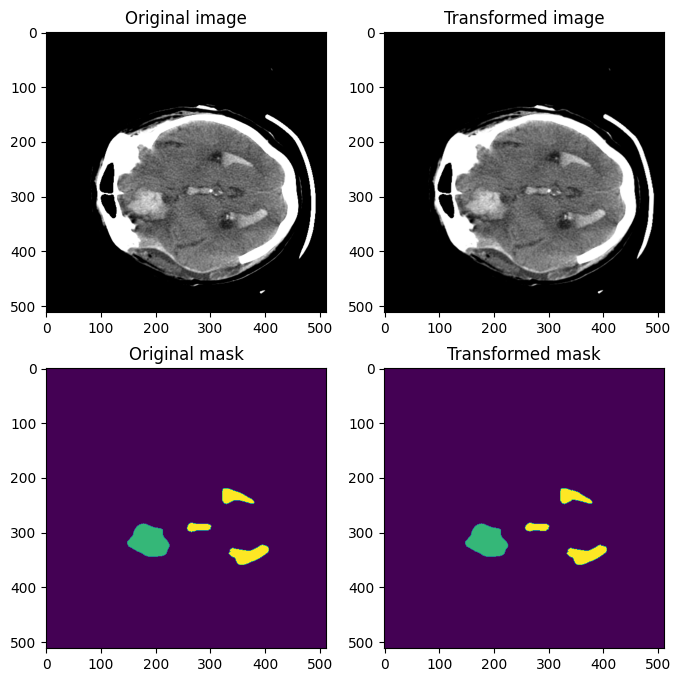

In [5]:
transform = A.Compose([
    A.ElasticTransform(
    alpha=50,
    sigma=8,
    p=1.0
)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## PiecewiseAffine

`PiecewiseAffine` 是 Albumentations 图像增强库中的一种几何变换方法，它可以对图像进行 **分段仿射变换（Piecewise Affine Transformation）**，从而模拟非刚性形变，常用于数据增强尤其是医学图像、手写数字、文档、OCR等领域。

### 使用场景 

-   **医学图像**：模拟不同患者之间器官、组织的形变；

-   **人脸识别**：模拟面部表情变化；

-   **文档识别 / OCR**：模拟扫描扭曲、印刷偏差等；

-   **手写数字识别（如 MNIST）**：增强数字样式多样性；

-   **一般目标检测 / 语义分割**：提供局部扰动增强鲁棒性；

### 参数解析 

| 参数名                      | 类型                        | 默认值              | 说明                                                         |
| --------------------------- | --------------------------- | ------------------- | ------------------------------------------------------------ |
| `scale`                     | `float` 或 `(float, float)` | `(0.03, 0.05)`      | 控制每个子图像角点偏移的标准差（高斯分布）。<br/>单个值表示 `(0, scale)` 范围。推荐：<br/>\- 小变形：`(0.01, 0.05)`<br/>\- 大变形：`(0.05, 0.1)` |
| `nb_rows`                   | `int` 或 `(int, int)`       | `4`                 | 网格的行数（≥2）。<br/>图像越大建议值越大。<br/>若为区间 `(a, b)`，每次会随机采样一个整数。 |
| `nb_cols`                   | `int` 或 `(int, int)`       | `4`                 | 网格的列数（≥2）。<br/>行为与 `nb_rows` 类似。               |
| `interpolation`             | `OpenCV 插值方法`           | `cv2.INTER_LINEAR`  | 图像插值方法。常用选项：<br/>`INTER_NEAREST`、`INTER_LINEAR`、`INTER_CUBIC`、`INTER_AREA`、`INTER_LANCZOS4` |
| `mask_interpolation`        | `OpenCV 插值方法`           | `cv2.INTER_NEAREST` | 用于 mask 的插值方法。通常应使用 `INTER_NEAREST` 保留离散标签。 |
| `absolute_scale`            | `bool`                      | `False`             | `True` 表示 `scale` 是绝对像素值；<br/>`False` 表示是相对于图像尺寸的比例。 |
| `keypoint_remapping_method` | `"mask"` 或 `"direct"`      | `"mask"`            | 关键点映射方式：<br/>`mask` 快速但大变形不精确；<br/>`direct` 精确但慢，适合大变形少量关键点。 |
| `p`                         | `float`                     | `0.5`               | 应用此变换的概率。                                           |



D:\Apps\anaconda3\envs\nnunet\lib\site-packages\albumentations\core\validation.py:114: UserWarning: This augmenter is very slow. Try to use ``ElasticTransform`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


Image shape: (512, 512, 3), Label shape: (512, 512)


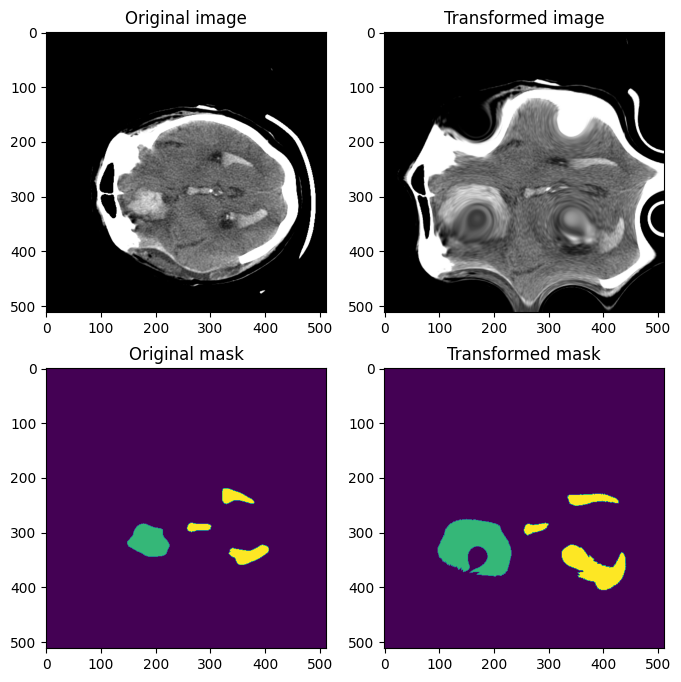

In [6]:
transform = A.Compose([
    A.PiecewiseAffine(scale=(0.02, 0.04), nb_rows=4, nb_cols=4, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## OpticalDistortion

`OpticalDistortion` 是 Albumentations 数据增强库中的一种几何变换，用于模拟 **光学畸变（optical distortion）** 的效果，特别是鱼眼镜头或低质量镜头造成的图像畸变现象。它可以提高模型在实际场景中对图像畸变的鲁棒性。

### 使用场景 

-   **场景分类/物体识别**：让模型适应摄像头拍摄角度偏差或变形；

-   **目标检测/分割**：提升模型在非标准图像采集条件下的泛化能力；

-   **自动驾驶**、**无人机图像**、**医学图像**：模拟镜头失真带来的形变。

### 参数解析 

| 参数名                      | 类型                             | 默认值              | 说明                                                         |
| --------------------------- | -------------------------------- | ------------------- | ------------------------------------------------------------ |
| `distort_limit`             | `float` 或 `tuple[float, float]` | `(-0.05, 0.05)`     | 畸变强度范围。<br/>推荐范围：<br/>• 相机模型：`(-0.05, 0.05)`<br/>• 鱼眼模型：`(-0.3, 0.3)` |
| `mode`                      | `Literal['camera', 'fisheye']`   | `'camera'`          | 使用的畸变模型：<br/>• `'camera'`：传统相机矩阵模型<br/>• `'fisheye'`：鱼眼镜头模型 |
| `interpolation`             | OpenCV 插值标志                  | `cv2.INTER_LINEAR`  | 图像畸变变换所使用的插值方法：<br/>• `cv2.INTER_NEAREST`<br/>• `cv2.INTER_LINEAR`<br/>• `cv2.INTER_CUBIC`<br/>• `cv2.INTER_AREA`<br/>• `cv2.INTER_LANCZOS4` |
| `mask_interpolation`        | OpenCV 插值标志                  | `cv2.INTER_NEAREST` | 掩膜图像的插值方法，选项同 `interpolation`。推荐使用最近邻以保留掩膜的离散标签特性。 |
| `keypoint_remapping_method` | `Literal["direct", "mask"]`      | `"mask"`            | 关键点重映射方式：<br/>• `"mask"`：使用掩膜映射，速度快，适合大量关键点或大图像<br/>• `"direct"`：使用逆变换，精度高，适合大畸变场景 |
| `p`                         | `float`                          | `0.5`               | 应用该变换的概率                                             |



Image shape: (512, 512, 3), Label shape: (512, 512)


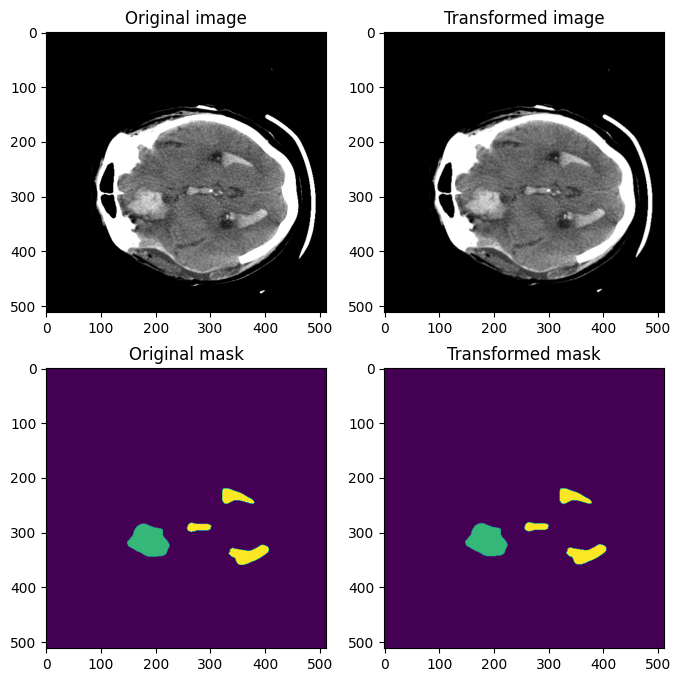

In [7]:
transform = A.Compose([
    A.OpticalDistortion(distort_limit=0.05, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## GridDistortion

`GridDistortion` 是一种用于图像增强的几何变换方法，主要用于模拟图像的局部弹性变形或网格形变，常用于提升模型对形变鲁棒性，尤其适用于医学影像、手写数字识别、OCR等任务。

### 使用场景 

-   **医学图像增强**：仿真组织非刚性形变，提高模型对组织形态变化的鲁棒性。

-   **手写文字识别**：模拟不同人的书写变形风格。

-   **人脸识别/姿态估计**：增强对局部表情变化的鲁棒性。

-   **OCR / 文档分析**：仿真扫描文档中的纸张弯曲或打印扭曲。

### 参数解析 

| 参数名称                    | 类型                           | 说明                                                         | 默认值              |
| --------------------------- | ------------------------------ | ------------------------------------------------------------ | ------------------- |
| `num_steps`                 | int                            | 每边网格单元数。数值越大，扭曲越细腻。最少为1。              | 5                   |
| `distort_limit`             | float 或 tuple\[float, float\] | 扭曲范围。如果是单个浮点数，范围为 (-distort\_limit, distort\_limit)。范围应在 -1 到 1 之间，数值越大扭曲越强烈。 | (-0.3, 0.3)         |
| `interpolation`             | int                            | 用于图像变换的 OpenCV 插值方法，如 `cv2.INTER_LINEAR`, `cv2.INTER_CUBIC` 等。 | `cv2.INTER_LINEAR`  |
| `normalized`                | bool                           | 是否保证扭曲后像素不会移出图像边界。开启后扭曲较小但不会丢失信息。 | True                |
| `mask_interpolation`        | int                            | 用于 mask 变换的插值方法，应为 `cv2.INTER_NEAREST`, `cv2.INTER_LINEAR`, `cv2.INTER_CUBIC`, `cv2.INTER_AREA`, `cv2.INTER_LANCZOS4` 中之一。 | `cv2.INTER_NEAREST` |
| `keypoint_remapping_method` | "direct" 或 "mask"             | 关键点重映射方法：<br/>\- `"mask"`：基于 mask 的映射，速度快，适合大量关键点或大图，但扭曲大时准确度稍差。<br/>\- `"direct"`：基于逆映射，准确但较慢 |                     |
| `p`                         | float                          | 应用该变换的概率。                                           | 0.5                 |



Image shape: (512, 512, 3), Label shape: (512, 512)


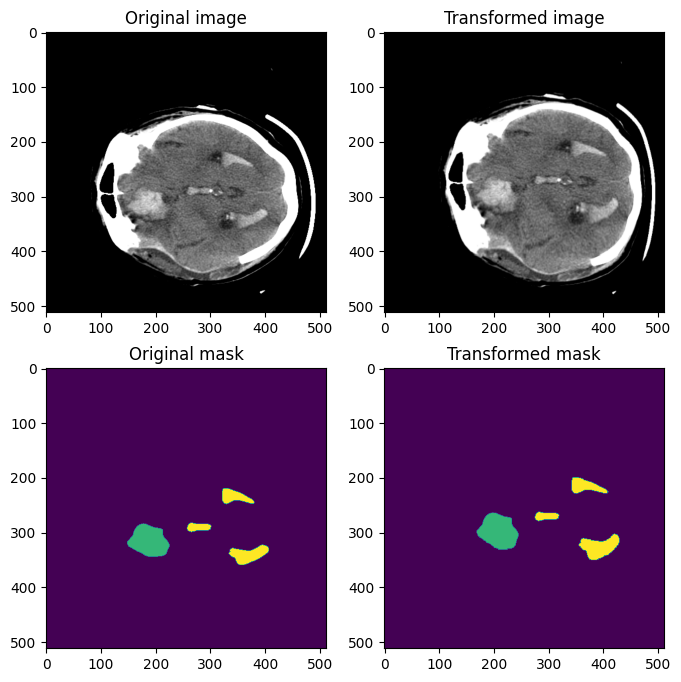

In [8]:
transform = A.Compose([
    A.GridDistortion(num_steps=5, distort_limit=0.3, normalized=True, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## ThinPlateSpline

`ThinPlateSpline`  是一种常用的非线性图像变形方法，用于对图像进行平滑的、灵活的形状变换。它基于插值原理，将控制点从原始位置映射到目标位置，通过优化弹性曲面（类似于一块薄金属板的变形形态），使图像变形既平滑又连续。

### 使用场景 

-   **医学影像**：人体器官有自然形变，TPS变形可以模拟这种非刚性形变，增加模型对形状变化的适应能力。

-   **人脸识别/表情识别**：模拟面部表情导致的非刚性形变。

-   **手写文字识别**：手写字形态多变，TPS变形能增加训练样本的多样性。

-   **一般图像增强**：在物体形状可能变化的场景中，比如服装、物体识别等，模拟轻微弯曲变形。

### 参数解析 

| 参数名                          | 类型                              | 说明                                                         | 默认值              |
| ------------------------------- | --------------------------------- | ------------------------------------------------------------ | ------------------- |
| **scale\_range**                | `tuple[float, float]`             | 控制点随机位移的范围，取值范围 `[0.0, 1.0]`：<br/>\- 0.0：无位移（恒等变换）<br/>\- 0.1：轻微变形<br/>\- 0.2-0.4：中等变形（推荐）<br/>\- 0.5+：强变形 |                     |
| **num\_control\_points**        | `int`                             | 每边控制点数，形成 `num_control_points x num_control_points` 网格：<br/>\- 2：最小变形（类似仿射）<br/>\- 3-4：中等灵活性（推荐）<br/>\- 5+：更多局部控制<br/>必须≥2 |                     |
| **interpolation**               | `int`                             | OpenCV 插值标志，用于图像采样。详见 `cv2.INTER_*`，如 `cv2.INTER_LINEAR` | `cv2.INTER_LINEAR`  |
| **mask\_interpolation**         | `int`                             | OpenCV 插值标志，用于掩码采样。详见 `cv2.INTER_*`，如 `cv2.INTER_NEAREST` | `cv2.INTER_NEAREST` |
| **keypoint\_remapping\_method** | `"direct"` 或 `"mask"`（Literal） | 关键点重映射方法：<br/>\- `"mask"`：基于掩码映射，速度快，适合大量关键点或大图，但大变形时精度稍差（推荐）<br/>\- `"direct"`：逆映射，精度高但速度较慢，适合大变形 |                     |
| **p**                           | `float`                           | 变换应用概率，范围0~1                                        | 0.5                 |



Image shape: (512, 512, 3), Label shape: (512, 512)


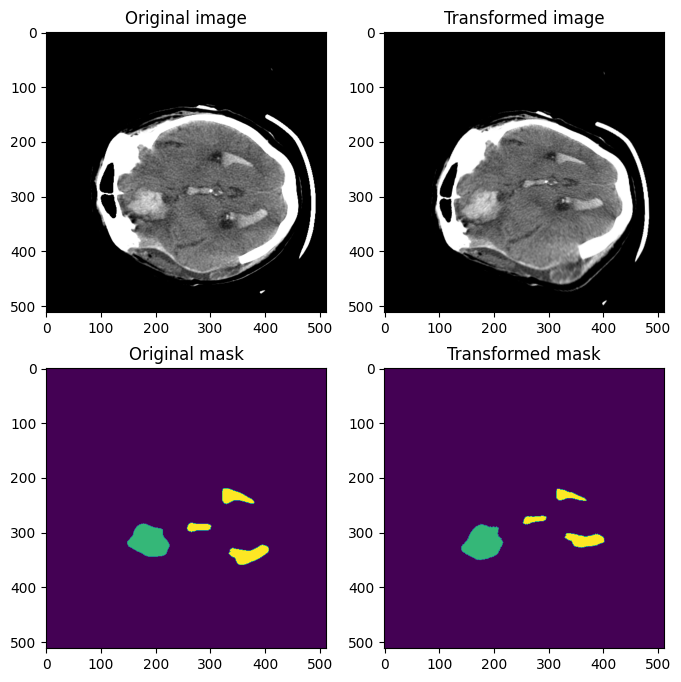

In [13]:
transform = A.Compose([
    A.ThinPlateSpline(num_control_points=4, scale_range=(0.05, 0.1), p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## VerticalFlip

`VerticalFlip` 是 `Albumentations` 图像增强库中的一个常用变换操作，用于对图像进行**垂直翻转**处理。

### 使用场景 

-   通过垂直翻转增加数据多样性，提高泛化能力。
-   数据中目标上下对称或方向不敏感时，可以使用。
-   上下方向敏感的任务（如交通标志识别、人脸朝向估计等），不建议使用垂直翻转，以免引入干扰。

### 参数解析 

| 参数名 | 类型  | 默认值 | 说明                                                         |
| ------ | ----- | ------ | ------------------------------------------------------------ |
| `p`    | float | `0.5`  | 应用该变换的概率，取值范围 `[0.0, 1.0]`。`p=1.0` 表示每张图都翻转，`p=0.0` 表示永远不翻转。 |

Image shape: (512, 512, 3), Label shape: (512, 512)


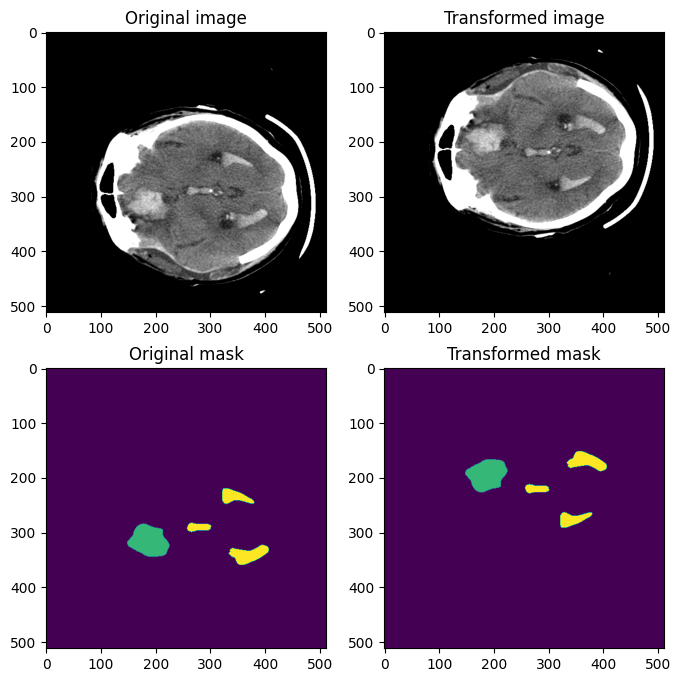

In [14]:
transform = A.Compose([
     A.VerticalFlip(p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## HorizontalFlip

`HorizontalFlip` 用于对图像进行 **水平翻转**，适用于计算机视觉任务中的数据增强，如目标检测、图像分类、语义分割等。

### 使用场景 

-   水平翻转可以提升模型的泛化能力，比如对称的物体或人脸等。
-   能增强模型对物体左右位置变化的鲁棒性。
-   能使模型更好地适应不同方向的目标形状。
-   对称的结构（如CT/MRI图像）翻转后依然保留语义，但需注意器官方向（如左肺、右肺）是否影响标签。

### 参数解析 

| 参数名 | 类型  | 默认值 | 说明                                                         |
| ------ | ----- | ------ | ------------------------------------------------------------ |
| `p`    | float | `0.5`  | 应用该变换的概率，取值范围 `[0.0, 1.0]`。`p=1.0` 表示每张图都翻转，`p=0.0` 表示永远不翻转。 |

Image shape: (512, 512, 3), Label shape: (512, 512)


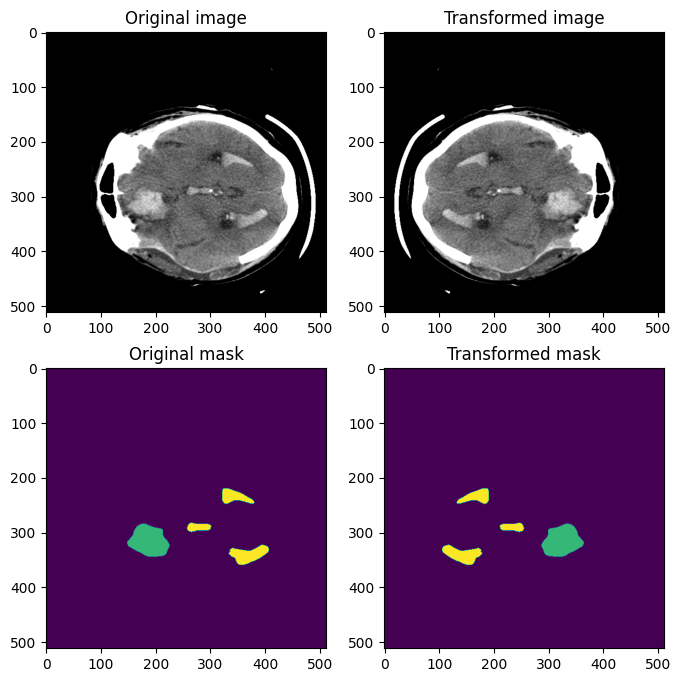

In [15]:
transform = A.Compose([
    A.HorizontalFlip(p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## Transpose

`Transpose` 是图像的转置操作，等价于将图像沿主对角线（左上到右下）进行翻转。

### 使用场景 

-   **图像分类**：增强数据多样性，提升模型泛化能力
-   **医学图像分析** ：CT/MRI 图像转置后仍保持解剖结构合理性，可用于水平/垂直方向的对称性学习
-   **OCR/手写识别**：模拟文字旋转方向的变化

### 参数解析 

| 参数名 | 类型  | 默认值 | 说明                                                         |
| ------ | ----- | ------ | ------------------------------------------------------------ |
| `p`    | float | `0.5`  | 应用该变换的概率，取值范围 `[0.0, 1.0]`。`p=1.0` 表示每张图都翻转，`p=0.0` 表示永远不翻转。 |

Image shape: (512, 512, 3), Label shape: (512, 512)


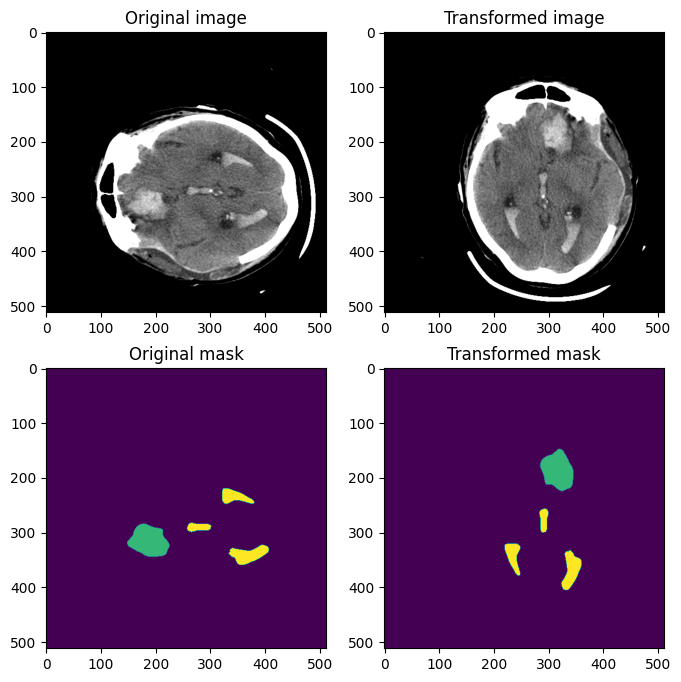

In [16]:
transform = A.Compose([
    A.Transpose(p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## RandomScale

`RandomScale` 用于对图像及其关联的目标（如目标检测框、分割掩码）进行**随机缩放（放大或缩小）**。

### 使用场景 

-   **目标检测和实例分割**：提高模型对不同物体尺寸的适应能力（例如远处的小物体和近处的大物体）
-   **图像分类**：增强模型对不同摄取距离或图像尺寸的泛化能力
-   **语义分割**：随机缩放可以模拟不同分辨率的图像输入，增强网络鲁棒性
-   **医学图像分析**：应对不同设备或采样参数下图像尺寸的变动

### 参数解析 

| 参数名               | 类型                                  | 默认值              | 说明                                                         |
| -------------------- | ------------------------------------- | ------------------- | ------------------------------------------------------------ |
| `scale_limit`        | `float` 或 `tuple[float, float]`      | `(-0.1, 0.1)`       | 缩放因子范围：<br/>\- 若为单个 `float`，则缩放范围为 `(1 - scale_limit, 1 + scale_limit)`；<br/>\- 若为 `tuple(low, high)`，则缩放范围为 `(1 + low, 1 + high)`。 |
| `interpolation`      | `int` (OpenCV 插值标志)               | `cv2.INTER_LINEAR`  | 图像缩放使用的插值方法，可选值：<br/>\- `cv2.INTER_NEAREST`<br/>\- `cv2.INTER_LINEAR`（默认）<br/>\- `cv2.INTER_CUBIC`<br/>\- `cv2.INTER_AREA`<br/>\- `cv2.INTER_LANCZOS4` |
| `mask_interpolation` | `int` (OpenCV 插值标志)               | `cv2.INTER_NEAREST` | 掩码缩放使用的插值方法，建议使用 `INTER_NEAREST` 保持类别边界清晰。可选项同上。 |
| `area_for_downscale` | `None` 或 `"image"` 或 `"image_mask"` | `None`              | 控制在**缩小时**是否自动启用 `INTER_AREA` 插值：<br/>\- `None`：始终使用指定的插值方法<br/>\- `"image"`：仅图像缩小时使用 `INTER_AREA`<br/>\- `"image_mask"`：图像和掩码缩小时都使用 `INTER_AREA` |
| `p`                  | `float`                               | `0.5`               | 应用该变换的概率，范围在 `[0, 1]`。                          |



Image shape: (550, 550, 3), Label shape: (550, 550)


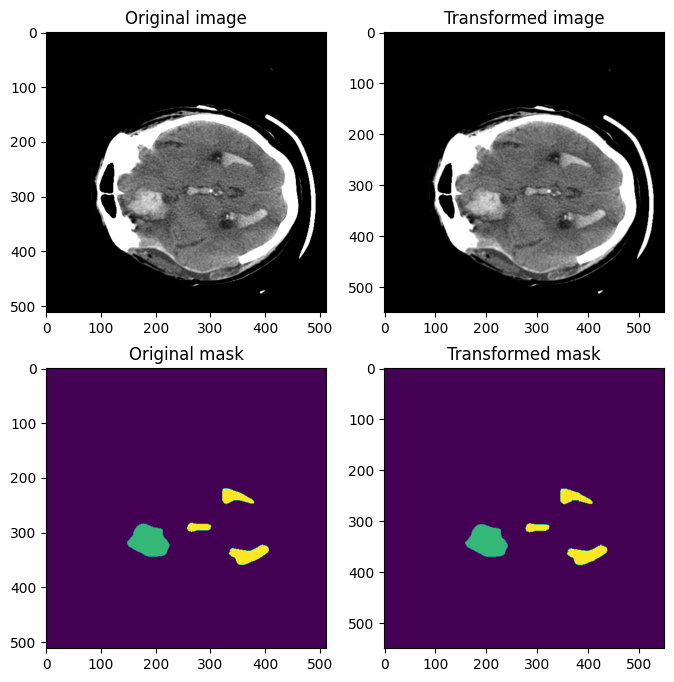

In [19]:
transform = A.Compose([
    A.RandomScale(scale_limit=0.2, p=1.0),
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## LongestMaxSize

`LongestMaxSize` 是 [Albumentations](https://albumentations.ai/) 数据增强库中的一个图像变换操作，主要用于 **按比例缩放图像的最长边**，将图像的最长边（宽或高）缩放为给定的最大尺寸，同时保持图像的长宽比（不裁剪）。

### 使用场景 

-   **保持图像纵横比** ： 不引入变形，提高模型泛化能力

### 参数解析 

| 参数名               | 类型                                   | 说明                                                         | 默认值              |
| -------------------- | -------------------------------------- | ------------------------------------------------------------ | ------------------- |
| `max_size`           | `int` 或 `Sequence[int]`               | 图像最长边缩放后的最大尺寸。若提供多个值（如列表或元组），则会从中随机选择一个。<br/> |                     |
| `interpolation`      | `int` (OpenCV 插值标志)                | 图像缩放时使用的插值方法，如 `cv2.INTER_LINEAR`, `cv2.INTER_NEAREST` 等 | `cv2.INTER_LINEAR`  |
| `mask_interpolation` | `int` (OpenCV 插值标志)                | 对掩码（mask）进行缩放时使用的插值方法，推荐使用 `cv2.INTER_NEAREST` 保持标签不连续性 | `cv2.INTER_NEAREST` |
| `area_for_downscale` | `Literal[None, "image", "image_mask"]` | 控制在图像缩小时是否自动使用 `INTER_AREA` 插值：<br/>\- `None`: 始终使用指定的插值方法<br/>\- `"image"`: 缩小时图像用 `INTER_AREA`，放大或 mask 用指定插值<br/>\- `"image_mask"`: 缩小时图像和 mask 都使用 `INTER_AREA` | `None`              |
| `p`                  | `float`                                | 应用该变换的概率，范围 0~1                                   | `1.0`               |

Image shape: (256, 256, 3), Label shape: (256, 256)


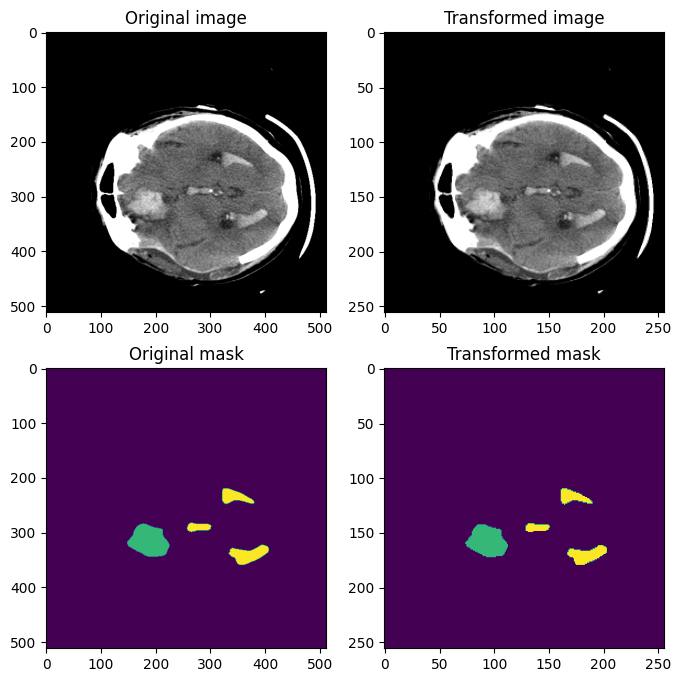

In [20]:
transform = A.Compose([
    A.LongestMaxSize(max_size=256)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## SmallestMaxSize

`SmallestMaxSize` 是 `albumentations` 图像增强库中的一个重要变换类，用于在**保持图像长宽比例**的前提下，**将图像的最小边缩放到指定大小**。

### 使用场景 

-   **保持图像纵横比** ： 不引入变形，提高模型泛化能力

### 参数解析 

| 参数名               | 类型                                   | 默认值              | 说明                                                         |
| -------------------- | -------------------------------------- | ------------------- | ------------------------------------------------------------ |
| `max_size`           | `int` 或 `List[int]`                   | `None`              | 图像最短边将被缩放到的最大值。如果是列表，则随机选择一个值。 |
| `interpolation`      | `int`（OpenCV 插值标志）               | `cv2.INTER_LINEAR`  | 图像缩放时使用的插值方式。常见选项：<br/>• `cv2.INTER_NEAREST`<br/>• `cv2.INTER_LINEAR`<br/>• `cv2.INTER_CUBIC`<br/>• `cv2.INTER_AREA`<br/>• `cv2.INTER_LANCZOS4` |
| `mask_interpolation` | `int`（OpenCV 插值标志）               | `cv2.INTER_NEAREST` | mask 缩放使用的插值方式，通常使用最近邻防止类别值失真。      |
| `area_for_downscale` | `Literal[None, "image", "image_mask"]` | `None`              | 控制是否在**图像下采样时自动使用 `INTER_AREA` 插值**：<br/>• `None`：始终使用指定插值方法<br/>• `"image"`：图像下采样时使用 `INTER_AREA`，其他情况不变<br/>• `"image_mask"`：图像和 mask 下采样都用 `INTER_AREA` |
| `p`                  | `float`                                | `1.0`               | 应用该变换的概率，默认始终应用。                             |



Image shape: (256, 256, 3), Label shape: (256, 256)


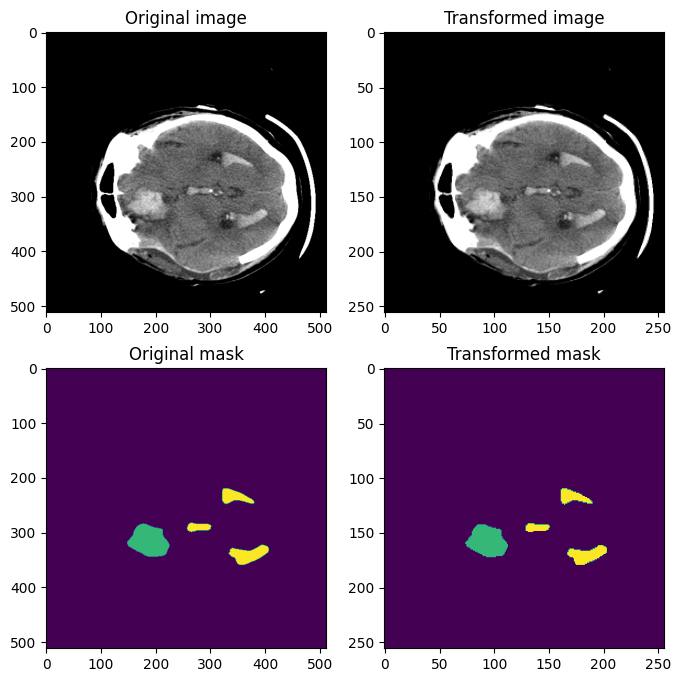

In [21]:
transform = A.Compose([
    A.SmallestMaxSize(max_size=256)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## Resize

`Resize` 是图像预处理和数据增强中最常用的操作之一。它的作用是将输入图像调整到指定的大小（宽度和高度），以便满足模型输入尺寸的要求，或者统一数据集中的图像尺寸。

### 使用场景 

-   深度学习模型通常需要固定尺寸的输入图像，方便批量处理

### 参数解析 

| 参数名                   | 类型                                    | 默认值              | 说明                                                         |
| ------------------------ | --------------------------------------- | ------------------- | ------------------------------------------------------------ |
| **height**               | int                                     | —                   | 输出图像的目标高度（像素）                                   |
| **width**                | int                                     | —                   | 输出图像的目标宽度（像素）                                   |
| **interpolation**        | OpenCV 插值标志（int）                  | `cv2.INTER_LINEAR`  | 图像插值算法，选项包括：<br/>`cv2.INTER_NEAREST`（最近邻）<br/>`cv2.INTER_LINEAR`（双线性，默认）<br/>`cv2.INTER_CUBIC`<br/>`cv2.INTER_AREA`<br/>`cv2.INTER_LANCZOS4` |
| **mask\_interpolation**  | OpenCV 插值标志（int）                  | `cv2.INTER_NEAREST` | 掩码（mask）插值算法，通常保持为最近邻插值以避免标签信息失真，选项同上 |
| **area\_for\_downscale** | Literal\[None, "image", "image\_mask"\] | None                | 控制自动使用 `INTER_AREA` 插值用于下采样的行为：<br/>\- `None`：不自动选择，始终用指定的插值方法<br/>\- `"image"`：下采样时图像用 `INTER_AREA`，其它情况用指定插值<br/>\- `"image_mask"`：图像和掩码下采样都用 `INTER_AREA` |
| **p**                    | float                                   | 1.0                 | 变换应用的概率，范围 0 到 1，默认总是应用                    |



Image shape: (348, 256, 3), Label shape: (348, 256)


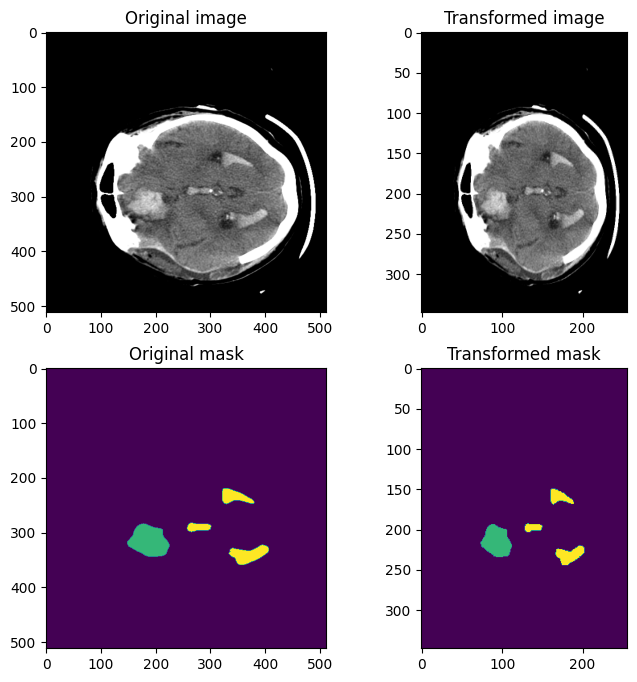

In [22]:
transform = A.Compose([
    A.Resize(height=348, width=256)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## PadIfNeeded

`PadIfNeeded` 是在图像的高度或宽度不足指定尺寸时，自动对图像进行边缘填充，使图像达到至少指定的最小高度和宽度。

### 使用场景 

-   深度学习模型通常需要固定尺寸的输入图像，方便批量处理

### 参数解析 

| 参数名               | 类型                                                         | 说明                                                         | 默认值                | 备注                           |
| -------------------- | ------------------------------------------------------------ | ------------------------------------------------------------ | --------------------- | ------------------------------ |
| `min_height`         | int 或 None                                                  | 期望的最小图像高度，保证图像高度至少达到此值。如果未指定，必须提供 `pad_height_divisor`。 | None                  | 和 `pad_height_divisor` 二选一 |
| `min_width`          | int 或 None                                                  | 期望的最小图像宽度，保证图像宽度至少达到此值。如果未指定，必须提供 `pad_width_divisor`。 | None                  | 和 `pad_width_divisor` 二选一  |
| `pad_height_divisor` | int 或 None                                                  | 如果设置，则填充图像高度使其能被此值整除。如果未指定，必须提供 `min_height`。 | None                  | 和 `min_height` 二选一         |
| `pad_width_divisor`  | int 或 None                                                  | 如果设置，则填充图像宽度使其能被此值整除。如果未指定，必须提供 `min_width`。 | None                  | 和 `min_width` 二选一          |
| `position`           | Literal\["center", "top\_left", "top\_right", "bottom\_left", "bottom\_right", "random"\] | 填充后图像放置的位置，默认为 `'center'`。                    | "center"              | 指定图像相对于填充区域的位置   |
| `border_mode`        | int                                                          | 填充时使用的边界模式，取值来自 OpenCV，例如 `cv2.BORDER_CONSTANT`。 | `cv2.BORDER_CONSTANT` | 控制填充方式，常用常数填充     |
| `fill`               | tuple\[float,...\] 或 float 或 None                          | 当 `border_mode=cv2.BORDER_CONSTANT` 时，填充像素的颜色值。  | None                  | 可为单通道或多通道颜色         |
| `fill_mask`          | tuple\[float,...\] 或 float 或 None                          | 类似 `fill`，但用于填充 mask 的像素值。                      | None                  | 用于填充 mask                  |
| `p`                  | float                                                        | 变换的概率。                                                 | 1.0                   | 控制变换是否执行               |



Image shape: (384, 384, 3), Label shape: (384, 384)


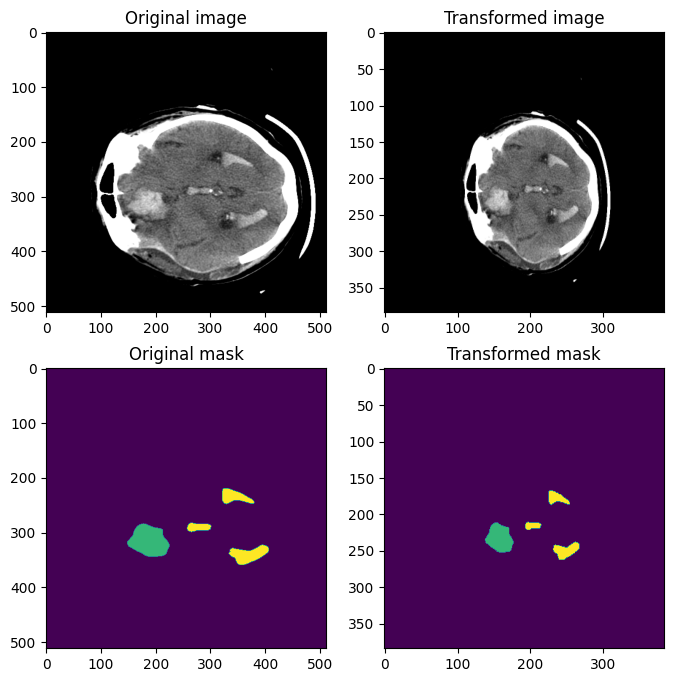

In [23]:
transform = A.Compose([
    A.Resize(height=348, width=256),
    A.PadIfNeeded(min_height=384, min_width=384)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## RandomRotate90

`RandomRotate90` 是在每次调用时随机以 90° 的倍数旋转输入图像（90°、180° 或 270°），从而增强模型的鲁棒性。

### 使用场景 

1.  **目标检测与分割任务** ：旋转后的图像仍保留目标的完整性，适合目标检测和语义分割数据增强。

2.  **医学影像分析** ：医学图像如CT、MRI等在一定角度旋转后依然保持解剖结构的有效信息，使用旋转90°的倍数变换可提高模型泛化能力。

3.  **卫星遥感影像**  ：卫星图像的方向性较弱，旋转增强帮助模型适应不同的拍摄角度。

4.  **一般图像分类任务**：对于某些分类任务，图像旋转可有效扩充训练集，尤其是物体方向不固定的场景。

### 参数解析 

| 参数名 | 类型  | 说明         | 默认值 | 备注             |
| ------ | ----- | ------------ | ------ | ---------------- |
| `p`    | float | 变换的概率。 | 1.0    | 控制变换是否执行 |



Image shape: (512, 512, 3), Label shape: (512, 512)


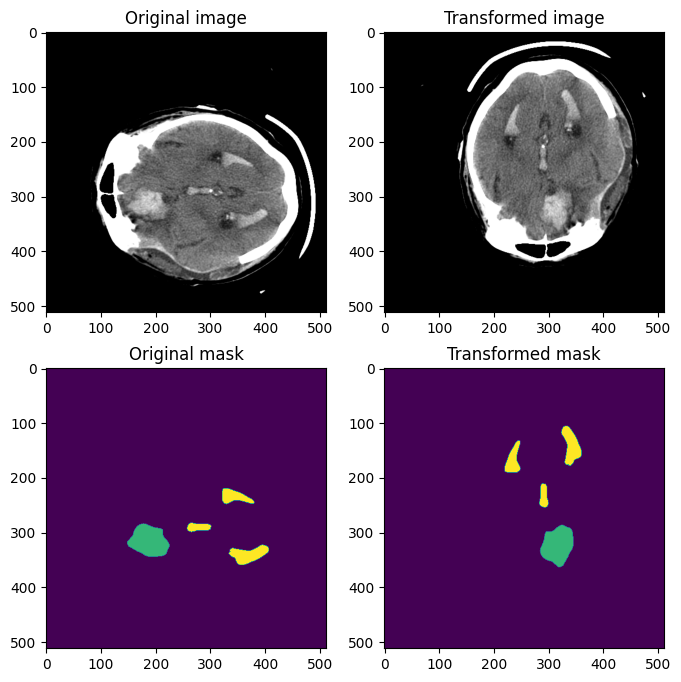

In [24]:
transform = A.Compose([
    A.RandomRotate90(p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## Rotate

`Rotate` 通过按指定角度旋转图像来生成图像的变体，从而增强模型的泛化能力。

### 使用场景 

-   **图像分类和识别**：对图像进行旋转，增加数据多样性，提高模型对不同角度物体的鲁棒性。

-   **目标检测和分割**：旋转图像的同时对标注框或掩码同步变换，提升模型对旋转物体的识别能力。

-   **医学图像处理**：旋转可以模拟实际拍摄角度的变化，提高模型对各种旋转姿态的适应能力。

-   **无人驾驶、遥感图像分析**：物体可能出现在不同角度，旋转增强提升模型稳定性。

### 参数解析 

| 参数名               | 类型                                 | 说明                                                         | 默认值                |
| -------------------- | ------------------------------------ | ------------------------------------------------------------ | --------------------- |
| `limit`              | float 或 tuple\[float, float\]       | 随机角度范围。如果是单个浮点数，则从 (-limit, limit) 中选择角度。 | (-90, 90)             |
| `interpolation`      | OpenCV 插值标志                      | 指定插值算法。可选：`cv2.INTER_NEAREST`, `cv2.INTER_LINEAR`, `cv2.INTER_CUBIC`, `cv2.INTER_AREA`, `cv2.INTER_LANCZOS4` | `cv2.INTER_LINEAR`    |
| `border_mode`        | OpenCV 边界扩展标志                  | 像素外推方法。可选：`cv2.BORDER_CONSTANT`, `cv2.BORDER_REPLICATE`, `cv2.BORDER_REFLECT`, `cv2.BORDER_WRAP`, `cv2.BORDER_REFLECT_101` | `cv2.BORDER_CONSTANT` |
| `fill`               | float 或 tuple\[float, ...\]         | 当 `border_mode=cv2.BORDER_CONSTANT` 时的填充值。            | 无（默认0填充）       |
| `fill_mask`          | float 或 tuple\[float, ...\]         | 同上，针对 mask 的填充值。                                   | 无                    |
| `rotate_method`      | 字符串 ("largest\_box" 或 "ellipse") | 旋转边界框的方法。选择 `'largest_box'`（旋转后最大包围盒）或 `'ellipse'`（椭圆方法）。 | `'largest_box'`       |
| `crop_border`        | bool                                 | 是否旋转后裁剪边界。若为 True，输出图像尺寸可能与输入不同。  | False                 |
| `mask_interpolation` | OpenCV 插值标志                      | mask 插值算法。可选同 `interpolation`。                      | `cv2.INTER_NEAREST`   |
| `p`                  | float                                | 该变换应用概率。                                             | 0.5                   |



Image shape: (512, 512, 3), Label shape: (512, 512)


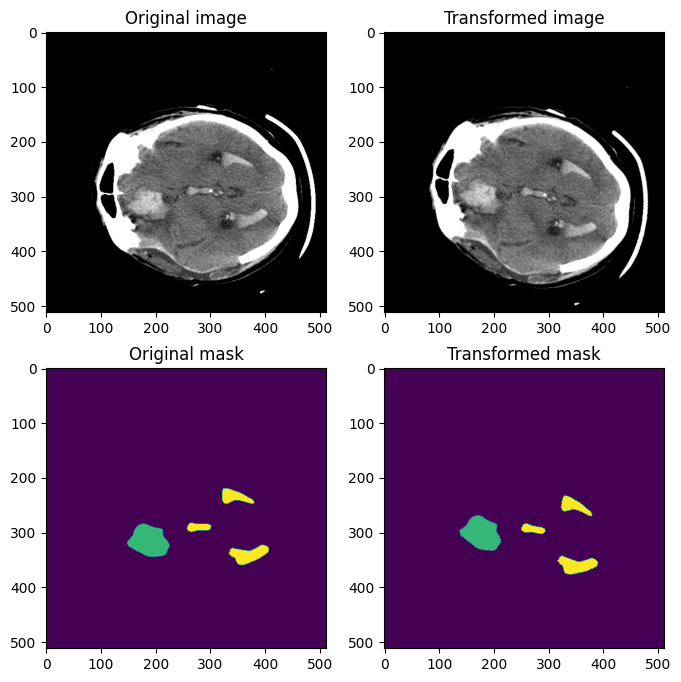

In [27]:
transform = A.Compose([
    A.Rotate(limit=40, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## SafeRotate

`SafeRotate` 用于安全地对图像进行旋转。它和普通的旋转变换的区别在于，`SafeRotate` 会自动调整输出图像的尺寸，以确保旋转后图像不会被裁剪（即不会丢失任何像素信息），且背景不会被填充成黑色或其他单一颜色，而是采用合理的方式填充。

### 使用场景 

-   **图像分类和识别**：对图像进行旋转，增加数据多样性，提高模型对不同角度物体的鲁棒性。

-   **目标检测和分割**：旋转图像的同时对标注框或掩码同步变换，提升模型对旋转物体的识别能力。

-   **医学图像处理**：旋转可以模拟实际拍摄角度的变化，提高模型对各种旋转姿态的适应能力。

-   **无人驾驶、遥感图像分析**：物体可能出现在不同角度，旋转增强提升模型稳定性。

### 参数解析 

| 参数名               | 类型                             | 说明                                                         | 默认值                   |
| -------------------- | -------------------------------- | ------------------------------------------------------------ | ------------------------ |
| `limit`              | `float` 或 `tuple[float, float]` | 随机选择旋转角度的范围。如果是单个 float，则角度从 `(-limit, limit)` 中随机选取。 | `(-90, 90)`              |
| `interpolation`      | OpenCV 插值标志                  | 指定图像插值算法。可选值：`cv2.INTER_NEAREST`、`cv2.INTER_LINEAR`、`cv2.INTER_CUBIC`、`cv2.INTER_AREA`、`cv2.INTER_LANCZOS4`。 | `cv2.INTER_LINEAR`       |
| `border_mode`        | OpenCV 边界模式标志              | 指定像素外推填充方式。可选值：`cv2.BORDER_CONSTANT`、`cv2.BORDER_REPLICATE`、`cv2.BORDER_REFLECT`、`cv2.BORDER_WRAP`、`cv2.BORDER_REFLECT_101`。 | `cv2.BORDER_REFLECT_101` |
| `fill`               | `float` 或 `tuple[float, float]` | 当 `border_mode=cv2.BORDER_CONSTANT` 时使用的填充值。        | 无（默认不使用）         |
| `fill_mask`          | `float` 或 `tuple[float, float]` | mask 的边界填充值，仅在 `border_mode=cv2.BORDER_CONSTANT` 时有效。 | 无（默认不使用）         |
| `rotate_method`      | `"largest_box"` 或 `"ellipse"`   | 用于旋转 bounding boxes 的方式：`largest_box` 表示使用最小外接矩形，`ellipse` 表示使用椭圆方法（更平滑）。 | `"largest_box"`          |
| `mask_interpolation` | OpenCV 插值标志                  | 用于 mask 插值的算法。通常使用 `cv2.INTER_NEAREST` 以保留标签整数值。 | `cv2.INTER_NEAREST`      |
| `p`                  | `float`                          | 应用该变换的概率。                                           | `0.5`                    |



Image shape: (512, 512, 3), Label shape: (512, 512)


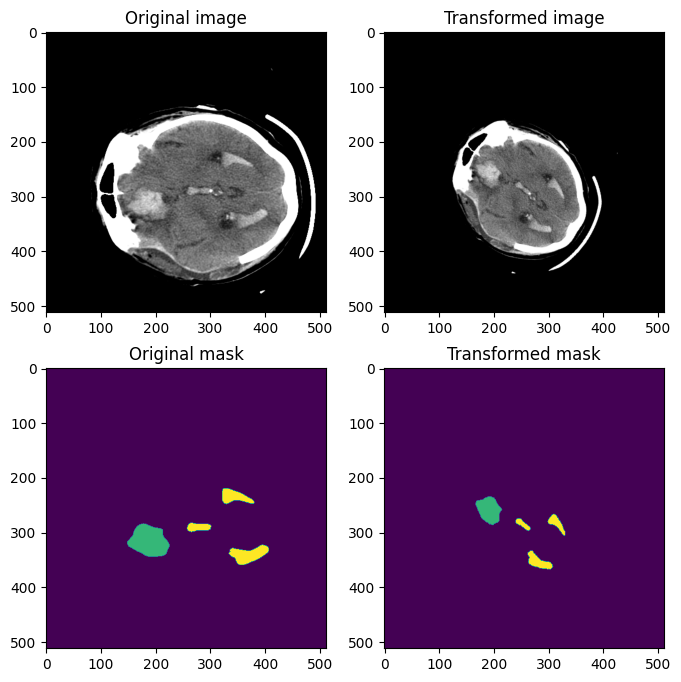

In [30]:
transform = A.Compose([
    A.SafeRotate(limit=40, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)